<a href="https://colab.research.google.com/github/Anspire/Notebooks/blob/master/Using_Otsu%E2%80%99s_method_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using Otsu’s method to generate data for training of deep learning image segmentation models

In [1]:
!wget https://notebooks.azure.com/clewolff/libraries/otsu/raw/golf1.jpg
!wget https://notebooks.azure.com/clewolff/libraries/otsu/raw/golf2.jpg

--2019-09-27 04:50:19--  https://notebooks.azure.com/clewolff/libraries/otsu/raw/golf1.jpg
Resolving notebooks.azure.com (notebooks.azure.com)... 13.65.37.122
Connecting to notebooks.azure.com (notebooks.azure.com)|13.65.37.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141083 (138K) [image/jpeg]
Saving to: ‘golf1.jpg’

golf1.jpg           100%[===================>] 137.78K   377KB/s    in 0.4s    

2019-09-27 04:50:21 (377 KB/s) - ‘golf1.jpg’ saved [141083/141083]

--2019-09-27 04:50:22--  https://notebooks.azure.com/clewolff/libraries/otsu/raw/golf2.jpg
Resolving notebooks.azure.com (notebooks.azure.com)... 13.65.37.122
Connecting to notebooks.azure.com (notebooks.azure.com)|13.65.37.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124611 (122K) [image/jpeg]
Saving to: ‘golf2.jpg’

golf2.jpg           100%[===================>] 121.69K   334KB/s    in 0.4s    

2019-09-27 04:50:23 (334 KB/s) - ‘golf2.jpg’ saved [124611/12461

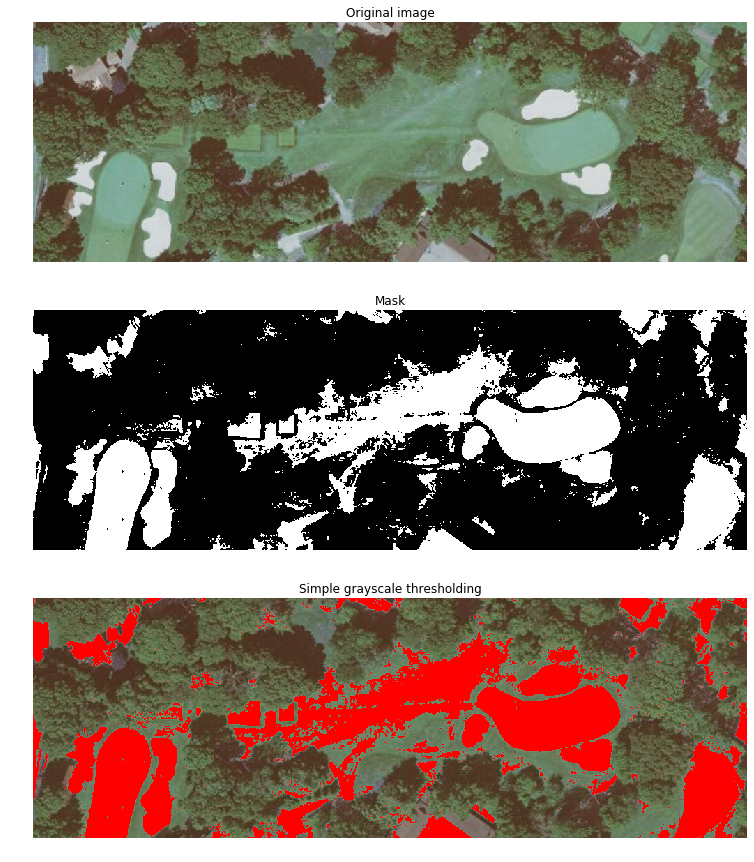

In [5]:
import cv2
import matplotlib.pyplot as plt

def compute_simple_mask(image):
  image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.threshold(image_grayscale, 127, 255, 0)[1]
 
 
image_path = 'golf1.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
mask_simple = compute_simple_mask(image)
 
 
def show_mask(mask, image, title, mask_color=(255, 0, 0)):
  masked_image = image.copy()
  masked_image[mask != 0] = mask_color
  images = [image, mask, masked_image]
  titles = ['Original image', 'Mask', title]
  fig, axs = plt.subplots(nrows = len(images), ncols = 1, figsize = (15, 15))
  for i, p in enumerate(images):
    axs[i].imshow(p, 'gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')
  plt.show()
 
 
show_mask(mask_simple, image, title='Simple grayscale thresholding')

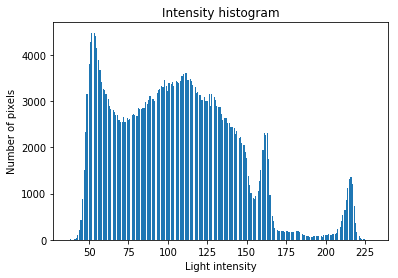

In [6]:
def show_intensity_histogram(image):
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.hist(image_grayscale.ravel(), 256)
    plt.title('Intensity histogram')
    plt.ylabel('Number of pixels')
    plt.xlabel('Light intensity')
    plt.show()
 
 
show_intensity_histogram(image)

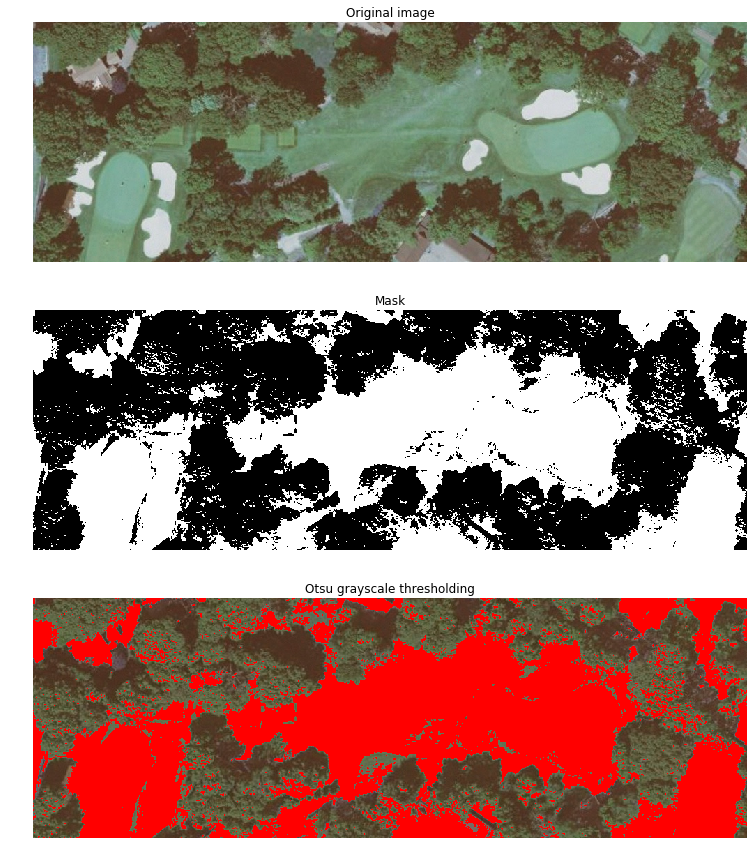

In [7]:
def compute_otsu_mask(image):
  image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.threshold(image_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
 
 
mask_otsu = compute_otsu_mask(image)
show_mask(mask_otsu, image, title='Otsu grayscale thresholding')

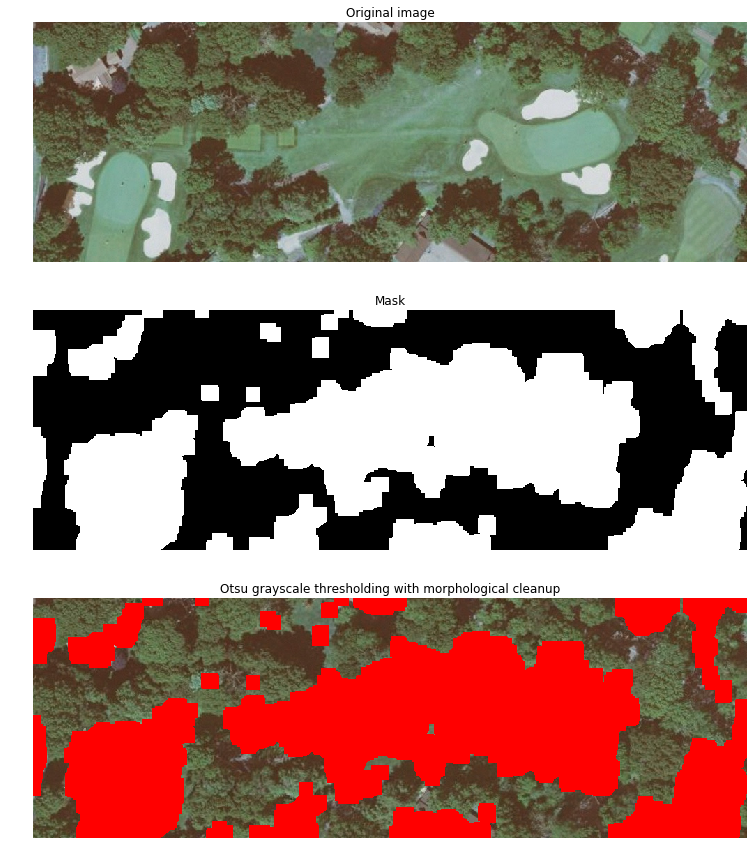

In [8]:
import numpy as np
 
kernel = np.ones((5, 5), np.uint8)
 
mask_otsu_clean = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, kernel, iterations=2)
mask_otsu_clean = cv2.erode(mask_otsu_clean, kernel, iterations=2)
mask_otsu_clean = cv2.dilate(mask_otsu_clean, kernel, iterations=5)
 
show_mask(mask_otsu_clean, image, title='Otsu grayscale thresholding with morphological cleanup')

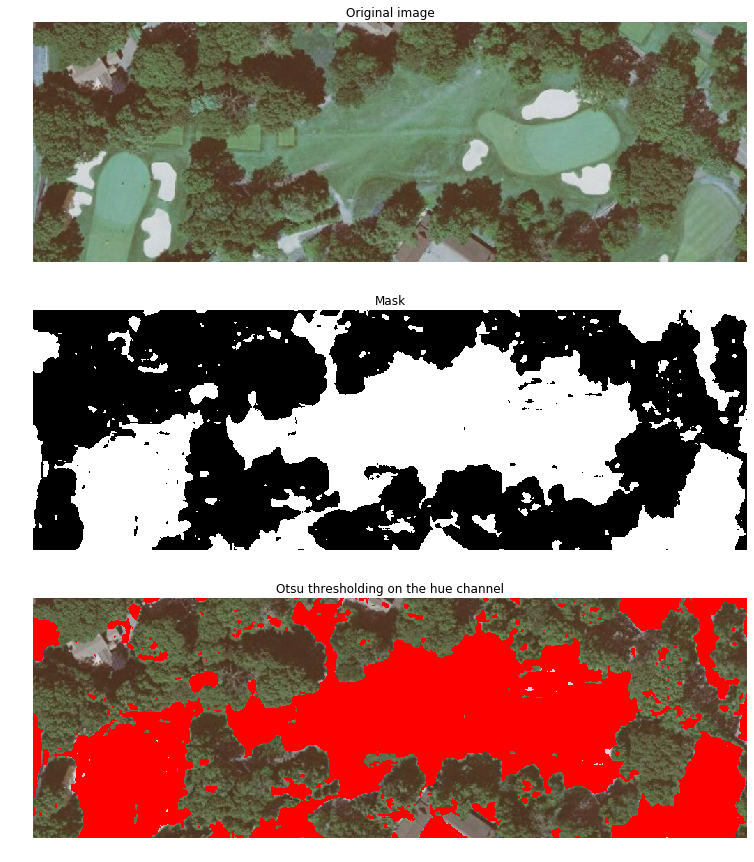

In [9]:
def compute_otsu_mask_hue(image):
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
 
    hue, lightness, saturation = np.split(image_hls, 3, axis=2)
 
    hue = hue.reshape((hue.shape[0], hue.shape[1]))
 
    otsu = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    otsu_mask = otsu != 255
 
    return otsu_mask
 
 
mask_otsu_hue = compute_otsu_mask_hue(image)
show_mask(mask_otsu_hue, image, title='Otsu thresholding on the hue channel')

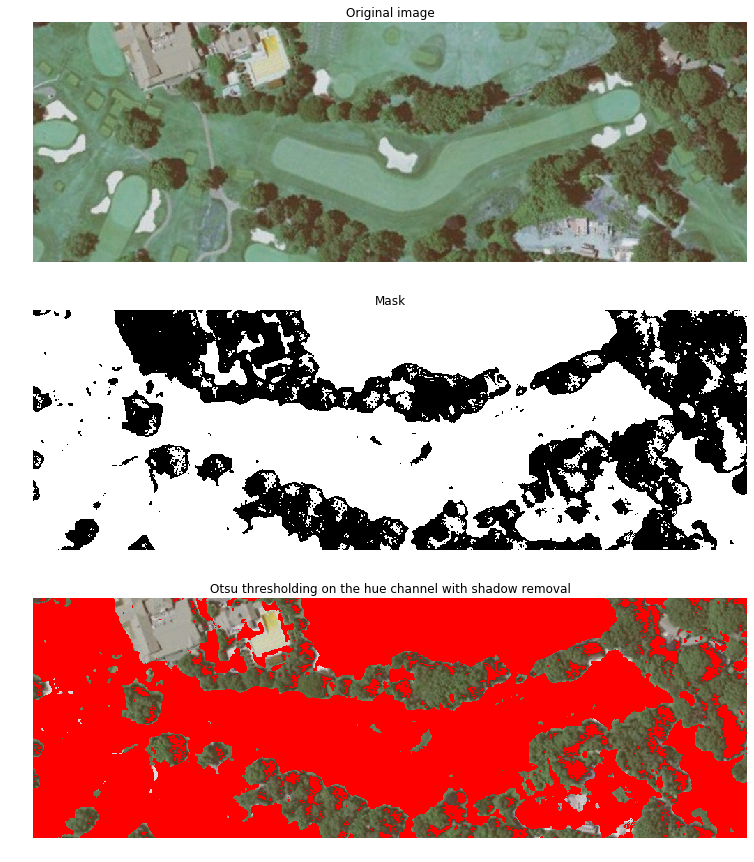

In [10]:
def compute_otsu_mask_shadows(image, shadow_percentile=5):
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
 
    hue, lightness, saturation = np.split(image_hls, 3, axis=2)
    hue = hue.reshape((hue.shape[0], hue.shape[1]))
 
    otsu = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    otsu_mask = otsu != 255
 
    image_lab = cv2.cvtColor(image2, cv2.COLOR_BGR2LAB)
    l, a, b = np.split(image_lab, 3, axis=2)
    l = l.reshape((l.shape[0], l.shape[1]))
 
    shadow_threshold = np.percentile(l.ravel(), q=shadow_percentile)
    shadows_mask = l < shadow_threshold
 
    mask = otsu_mask ^ shadows_mask
 
    return mask
 
 
image_path2 = 'golf2.jpg'
image2 = cv2.imread(image_path2)
mask_otsu_shadows = compute_otsu_mask_shadows(image2)
show_mask(mask_otsu_shadows, image2, title='Otsu thresholding on the hue channel with shadow removal')